# Başlangıç ayarları

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from mypyext import ml #my custom package
from mypyext import pythonutility as pu
from mypyext import dataanalysis as da
from mypyext import extensions
import seaborn as sns
import matplotlib.pyplot as plt

all warnings will be shown


In [2]:
%load_ext autoreload
%autoreload 2

## Data temini

In [3]:
df=pd.read_excel("datasets/default of credit card clients.xlsx")
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


📌 Target: default payment (temerrüde düşme, yani borcu ödeyememe)

- 1 → Önümüzdeki ay temerrüde düşmüş
- 0 → Düşmemiş

📦 Feature Grupları

**Demografik Bilgiler**

- LIMIT_BAL → Kredi limiti
- SEX (1 = male; 2 = female)
- EDUCATION (1 = graduate school; 2 = university; 3 = high school; 4 = others)
- MARRIAGE (1 = married; 2 = single; 3 = others)
- AGE


**Ödeme Geçmişi (PAY_0 – PAY_6)**

Son 6 aya ait gecikme durumu

| Değer | Anlamı                                               |
| ----- | ---------------------------------------------------- |
| -2    | Hesapta harcama yok (O ay kredi kartı kullanılmamış.)|
| -1    | Zamanında ödeme                                      |
| 0     | Revolving credit (minimum ödeme yapmış, gecikme yok) |
| 1     | 1 ay gecikme                                         |
| 2     | 2 ay gecikme                                         |
| 3     | 3 ay gecikme                                         |
| ...   | ...                                                  |


**Fatura Tutarları (BILL_AMT1 – BILL_AMT6)**

- Son 6 aya ait fatura borcu (kart ekstresi)
- Negatif değerler: Müşteri bankaya borçlu değil, banka müşteriye borçlu.

**Ödeme Tutarları (PAY_AMT1 – PAY_AMT6)**

Son 6 aya ait yapılan ödeme miktarı

In [4]:
#temizlik
df.columns=df.iloc[0,:]
df=df.rename(columns={"default payment next month":"target"})
df.drop(0,inplace=True)
df.drop(["ID"],inplace=True,axis=1)
df.reset_index(drop=True,inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.super_info_()

,Type,Nunique(Excl.Nulls),#of Missing,MostFreqItem,MostFreqCount,First
0,,,,,,
LIMIT_BAL,object,81,0,50000,3365,20000
SEX,object,2,0,2,18112,2
EDUCATION,object,7,0,2,14030,2
MARRIAGE,object,4,0,2,15964,1
AGE,object,56,0,29,1605,24
PAY_0,object,11,0,0,14737,2
PAY_2,object,11,0,0,15730,2
PAY_3,object,11,0,0,15764,-1
PAY_4,object,11,0,0,16455,-1


ilk tespit : hiç missing yok

In [6]:
#hepsini numeric yapalım
df=df.apply(lambda x:pd.to_numeric(x, errors="coerce"))

In [7]:
#kolon tiplerini belirleyelim
ords=list(df.columns[5:11]) # -2 ve -1 ayrı bir kolonda nominal yapılabilir, daha iyisi yapılabilir.
noms=["SEX","MARRIAGE","EDUCATION"]
cats=ords+noms
nums=list(set(df.columns[:-1]).difference(set(cats)))

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


## Some EDA

### Genel

Multicollinearity var mı görelim

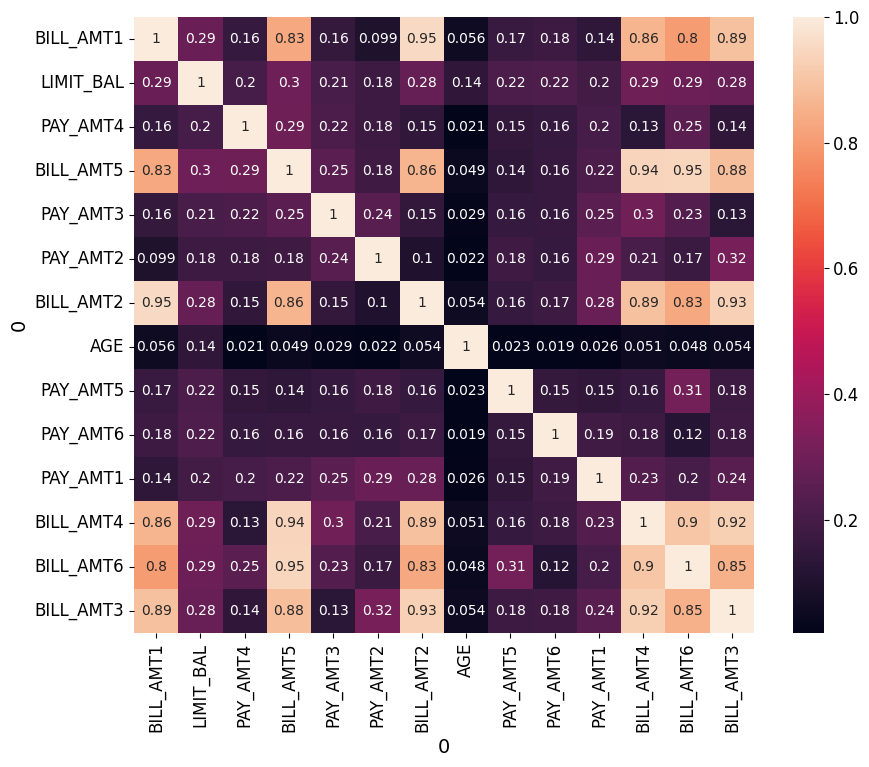

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df[nums].corr(),annot=True);

BILL_AMT'ler arasında yüksek korelasyon var görünüyor.

In [10]:
# sns.pairplot(df[nums],height=1.3, aspect=1.2);

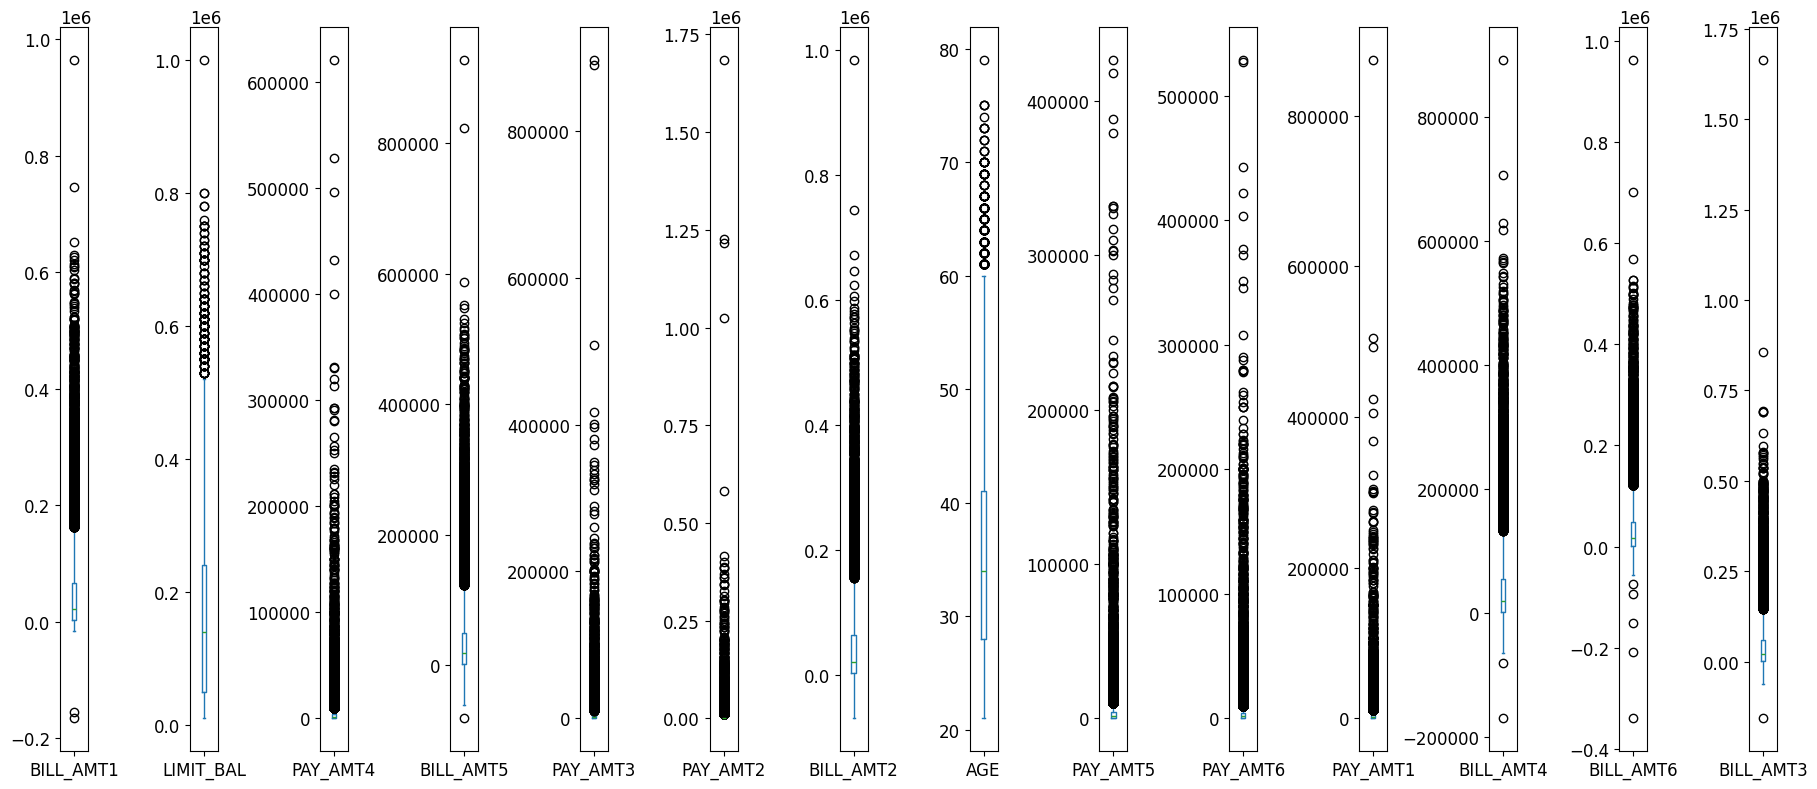

In [11]:
df[nums].plot(kind="box", subplots = True,figsize=(18,8))
plt.tight_layout();

Hemen her kolonda bayağı bi outlier var gibi görünüyor, çoğunlukla tree based algortimalar kullanacağım için outlier handling yapmayı düşünmüyorum.

In [12]:
da.outliers_IQR(df,nums,thresh=0.1)

280 outliers exists in feature 'BILL_AMT1'
1 outliers exists in feature 'LIMIT_BAL'
1001 outliers exists in feature 'PAY_AMT4'
282 outliers exists in feature 'BILL_AMT5'
964 outliers exists in feature 'PAY_AMT3'
999 outliers exists in feature 'PAY_AMT2'
283 outliers exists in feature 'BILL_AMT2'
973 outliers exists in feature 'PAY_AMT5'
1082 outliers exists in feature 'PAY_AMT6'
985 outliers exists in feature 'PAY_AMT1'
296 outliers exists in feature 'BILL_AMT4'
299 outliers exists in feature 'BILL_AMT6'
287 outliers exists in feature 'BILL_AMT3'


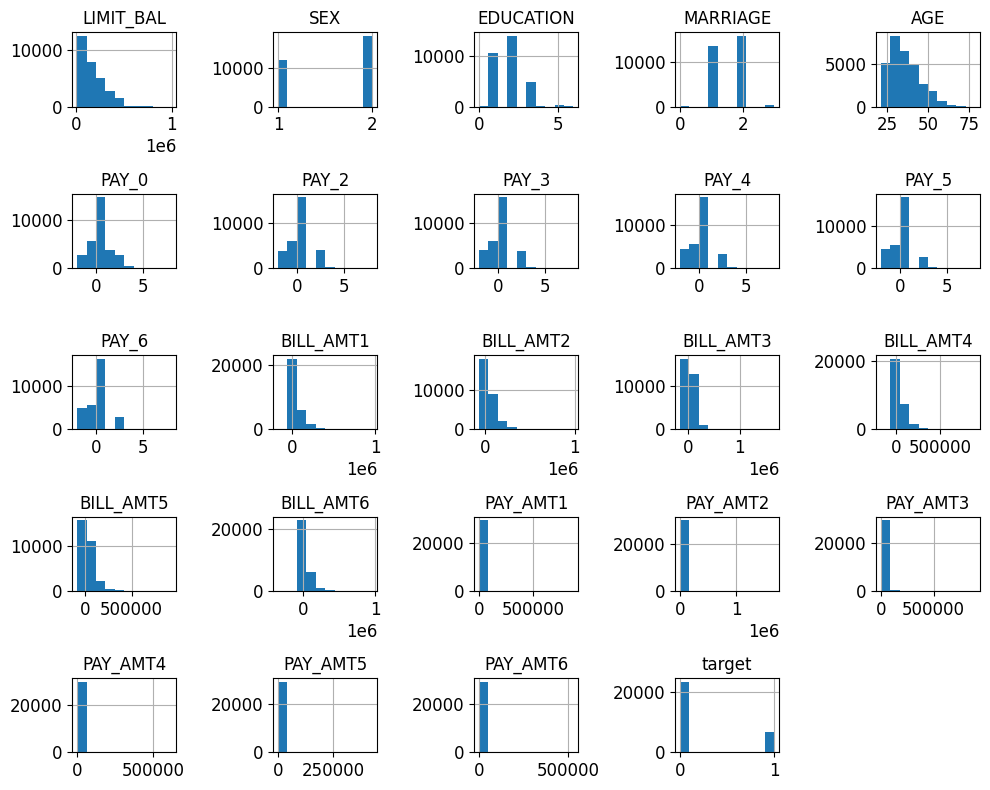

In [13]:
df.hist(figsize=(10,8))
plt.tight_layout();

In [14]:
da.getColumnsInLowCardinality(df,i=11)

Unique items in column SEX
[2 1]

Unique items in column EDUCATION
[2 1 3 5 4 6 0]

Unique items in column MARRIAGE
[1 2 3 0]

Unique items in column PAY_0
[ 2 -1  0 -2  1  3  4  8  7  5  6]

Unique items in column PAY_2
[ 2  0 -1 -2  3  5  7  4  1  6  8]

Unique items in column PAY_3
[-1  0  2 -2  3  4  6  7  1  5  8]

Unique items in column PAY_4
[-1  0 -2  2  3  4  5  7  6  1  8]

Unique items in column PAY_5
[-2  0 -1  2  3  5  4  7  8  6]

Unique items in column PAY_6
[-2  2  0 -1  3  6  4  7  8  5]

Unique items in column target
[1 0]

You may want to consider the numerics with low cardinality as categorical in the analysis


['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'target']

- Education ve marital statusta descriptionda olmayan değerler var, bakalım
- PAY_ ile başlayanlar da ordinal olup ,negatif değerler içeriyor, hepsini 2 artırıp negatiflerden kurtulma denenebilir

In [15]:
df.EDUCATION.value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

- 5,6,0 da 4 içine dahil edilebilir
- ordinal olabilir, bakalım, ama lineer bir ordniallik yok, nominal de yapılabilir

In [16]:
df.MARRIAGE.value_counts()

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

0 bilinmiyor, MNAR testi? ya da 3 ile birleştiriliebilir

### Target analysis

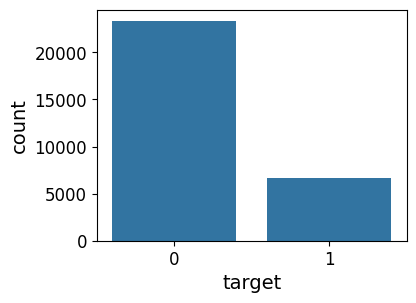

In [17]:
plt.figure(figsize=(4,3))
sns.countplot(x=df["target"]);

Imbalanced bir datasetimiz var. Modelleme aşamasında SMOTE uygulanabilir, ama işleri basit tutmak adına bu stepi es geçeceğim.

Şİmdi target bazında numeriklerin ortalama değerlerine bakalım.

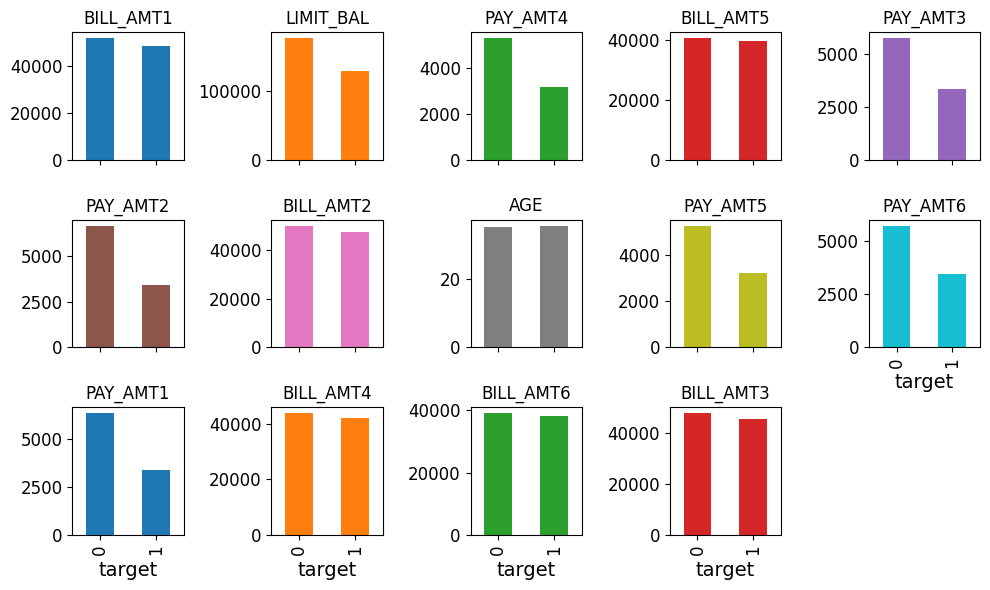

In [18]:
da.plotNumericsByTarget(df,"target",nums=nums,layout=(3,len(nums)//3+1),figsize=(10, 6))

- Pay_amt ile başlayanların ortalama değeri targeta göre oldukça değişken, demekki targetın tahmininide önemli bir rolü olacaklar.
- Limit Balancın da ortalama değeri targeta göre oldukça değişken, demekki targetın tahmininide önemli bir rolü olacak.
- Diğerlerinde çok belirgin bir etkileme durumu görünmüyor

Kategorik kolonlar üzerinden baktığımızda ilgili kategorilerdeki her default olma olasılıklarına(prior probability) bakalım.

In [19]:
cats

['PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'SEX',
 'MARRIAGE',
 'EDUCATION']

In [20]:
df2 = df.copy()
df2[cats] = df2[cats].astype(str) #daha şık grafik görünümü için

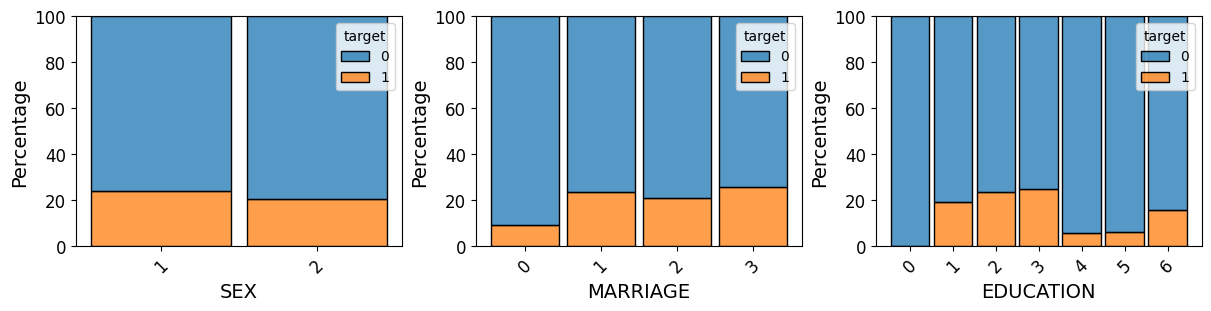

In [21]:
da.plotTargetByCatsWithN(df2, noms, "target", subplot_tpl=(1,3), mode="stacked_percent", show_n=False,figsize=(12,3))

YORUMLAR:

- Yapmamak lazım

Peki dedik ki bunların percentage olduğunu unutmayalım. Demek ki bu grafik bize birşeyleri göstermiyor olabilir, ama neyi?

Kategoriler arasındaki dağılım miktarını, dolayısıyla bu oranların ne kadar güvenilir olduğunu tam göstermiyor. Yani, eğer kategoriler arasında bir fark varsa bu fark anlamlı mı, bunu göstermiyor. Belki burdaki bir oran çok küçük bir grupta çıkan bir orandır. Böyle bir durumda bu yorumları yaparken dikkati olmak lazım.

O zaman bu grafiğin bir de kategorilerin mutlak rakamlarıyla olan halini çizdirelim.

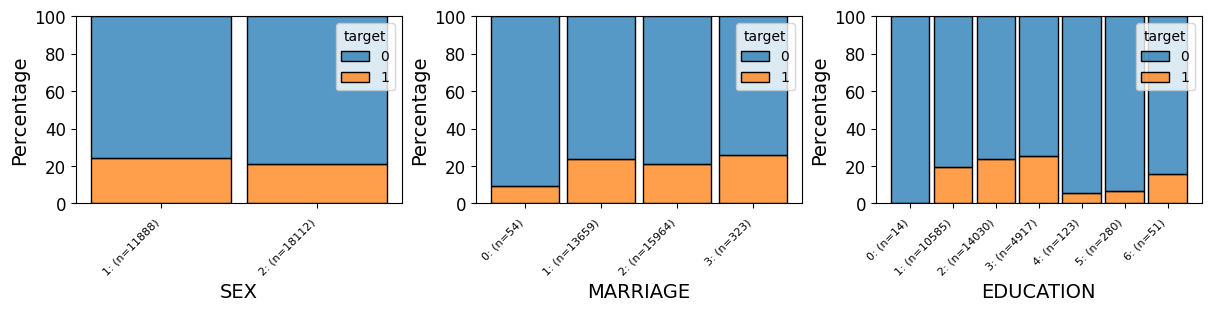

In [22]:
da.plotTargetByCatsWithN(df2, noms, "target", subplot_tpl=(1,3), mode="stacked_percent", show_n=True,figsize=(12,3))

In [23]:
# - SEX (1 = male; 2 = female)
# - EDUCATION (1 = graduate school; 2 = university; 3 = high school; 4 = others)
# - MARRIAGE (1 = married; 2 = single; 3 = others)

YORUM:


- Cinsiyet nasıl etkiliyor?
- Marriage "" ""
- Eğitim "" ""

Bir de sadece pozitif class için güven aralıkları dahil çizdirelim.

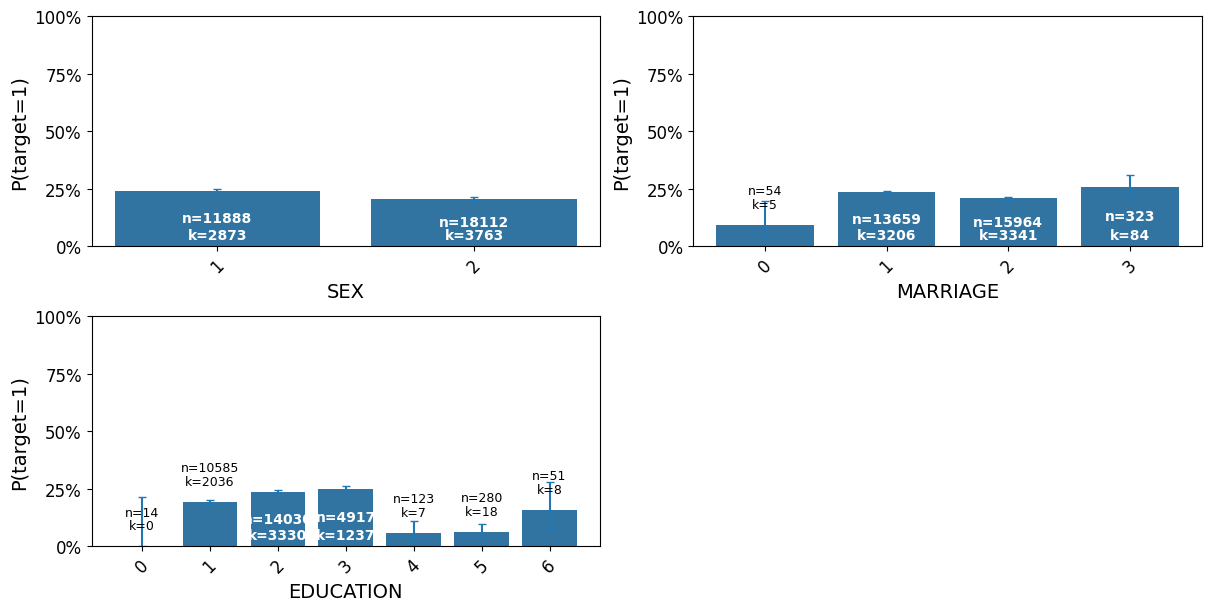

In [24]:
da.plotTargetByCatsWithN(df2, noms, "target", subplot_tpl=(2,2), mode="yes_rate_ci", show_n=True, figsize=(12,6), pos_label=1)

Yorumlar:

- 

### Korelasyonlar

Şimdi de korelasyonlara bakalım

In [25]:
from dython.nominal import cramers_v, correlation_ratio

In [26]:
#cat(target) vs cat
liste=[]
for c in [x for x in cats]:
    liste.append((c,cramers_v(df[c].values,df["target"].values),min(df[c].nunique()-1,df["target"].nunique()-1)))
    
sorted(liste,key=lambda x:x[1],reverse=True)

[('PAY_0', np.float64(0.4225376980470451), 1),
 ('PAY_2', np.float64(0.3398324070767322), 1),
 ('PAY_3', np.float64(0.29510161426216264), 1),
 ('PAY_4', np.float64(0.2787799211402479), 1),
 ('PAY_5', np.float64(0.27010908674532336), 1),
 ('PAY_6', np.float64(0.2501930992696595), 1),
 ('EDUCATION', np.float64(0.07239281703731822), 1),
 ('SEX', np.float64(0.03945897473696193), 1),
 ('MARRIAGE', np.float64(0.03299665874336609), 1)]

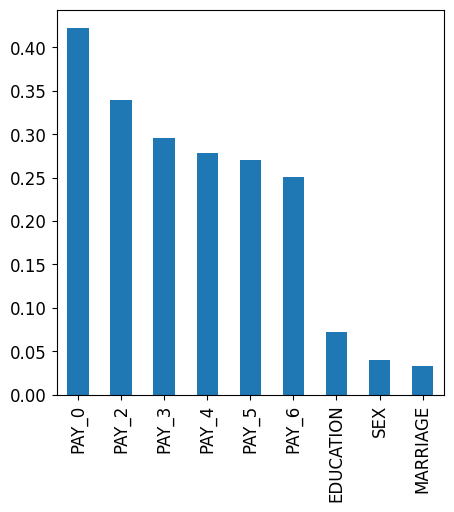

In [27]:
dict_={x[0]:x[1] for x in liste}
dict_sorted = dict(sorted(dict_.items(), key=lambda item: item[1], reverse=True))
pd.Series(dict_sorted).plot(kind="bar",figsize=(5,5));

Hepsindeki degre of freedom 1 olduğu için 0,3-0,5 arasını orta, 0,5 üstünü yüksek etkiye sahip diye yorumlayabiliriz. Buna göre sadece PAY_ ile başlayanların etkisi var gibi görünüyor.

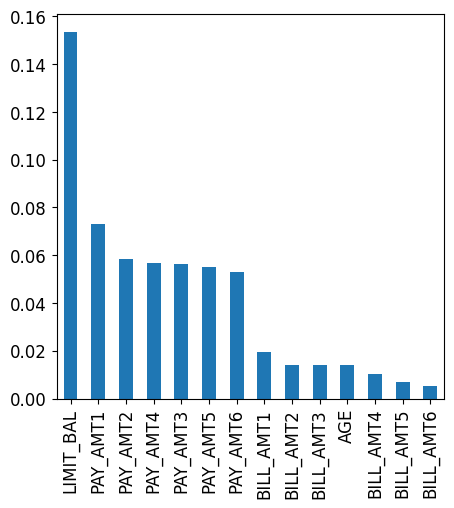

In [28]:
#cat(target) vs num
dict_={}
for num in nums:
    dict_[num]=correlation_ratio(df["target"].values,df[num].values)
    
dict_={k: v for k, v in sorted(dict_.items(), key=lambda item: item[1],reverse=True)}
pd.Series(dict_).plot(kind="bar",figsize=(5,5));

Hepsini targetla ilşkisi düşük olmakla birlikte, Limit balacnın etkisi diğerlerine göre açık ara önde, ki bunu yukarıdaki görsellerde de görmüştük.

## model selection

### X-y ve train-test ayrımı

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [30]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1].values

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42,stratify=y)

In [32]:
#classweights
cw={0:1, 1:2} 

In [33]:
def outputModel(clf):    
    print("Printing cross_val scores....\n")
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    print(cross_val_score(clf,X_train,y_train,n_jobs = -1,cv=cv,scoring="f1_weighted"))
    
    clf.fit(X_train,y_train)
    print("Printing train results....\n")
    y_pred_trn=clf.predict(X_train)
    print(classification_report(y_train,y_pred_trn))
    print("Printing test results....\n")
    y_pred_tst=clf.predict(X_test)
    print(classification_report(y_test,y_pred_tst))
    cm=confusion_matrix(y_test,y_pred_tst)
    cmp = ConfusionMatrixDisplay(cm,display_labels=clf.classes_)
    cmp.plot();

### Base modeller

In [34]:
plt.rcParams['axes.grid'] = False

#### LogReg

##### Varsayımların kontrolü

- Lineer Regresyonda olduğu gibi instanceların birbirinden bağımsız olması beklenir. Her biri farklı müşterilere ait, bazı featurelar arasında temporal bir bağ var ama instanceler arasında yok.
- Yine LinReg'de olduığu gibi featureler arasında collinearity olmaması gerekir: BU verisetinde en büüyk ihalle burada. **DİKKAT**
    - Feature selection
    - Regularization (L1/L2)
    - PCA, gruplu şekilde
    - feature extraction: Aggregated feature üretmek (ortalama gecikme gibi)
- Outlierlara karşı duyarlıdır, dikkatlice ele alınması gerekir: Çok sayıda outlier vardı, dikkat edilmeli. Ancak LinReg'in(OLS işleyişi nedeniyle) aksine aşırı duyarlılık olmadığı için agresif yöntemlerle ilerlenmemeli: RobustScaler veya winsorizing işe yarayabilir.
- Scaling'e duyarlıdır: Ölçeklerde farklılık var, scale edeceğiz.
- Instance sayısı feature sayısının en az bi 10-15 katı olmalıdır: Ok.
- Sürekli değişkenler(nums) ile logit arasında doğrusal ilişki (en kritik varsayım): Chol başta olmak üzere RestBP ve Ca kısmen ihlal ediyor. Çözüm olarak baremleme yapılabilir veya polinomial term eklenebilir (Aşağıdabu tespiti nasıl yaptığımız görünüyor)

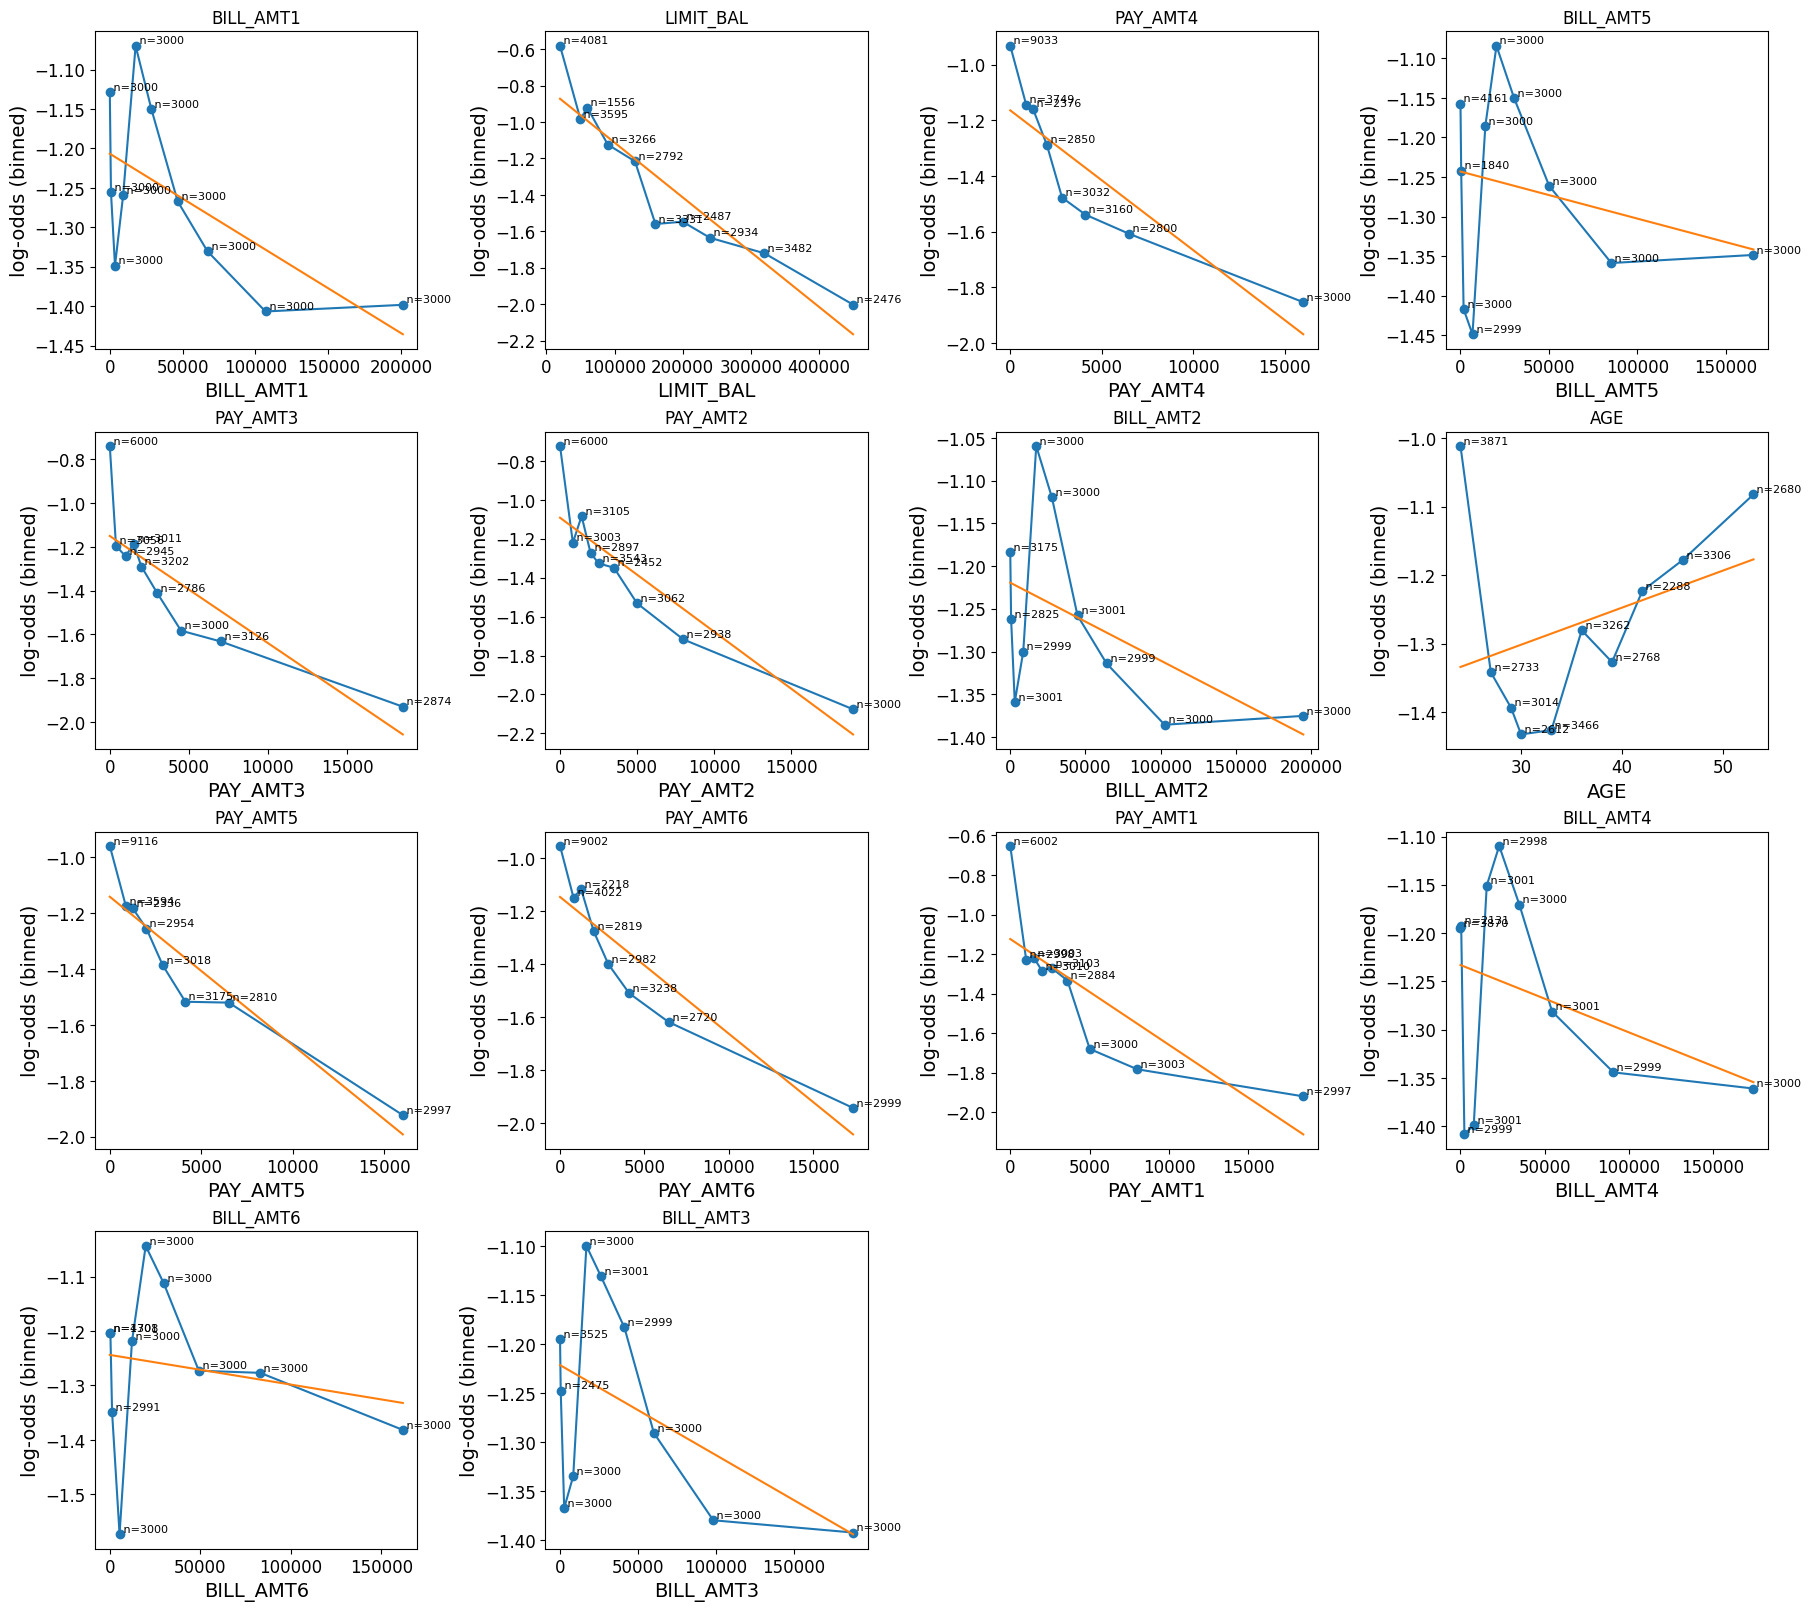

In [35]:
df_numeric = df.copy()
da.plot_binned_logodds_all(df_numeric, nums, target="target", pos_label=1, q=10, cols=4, figsize= (18,16))

In [36]:
nums, noms, ords

(['BILL_AMT1',
  'LIMIT_BAL',
  'PAY_AMT4',
  'BILL_AMT5',
  'PAY_AMT3',
  'PAY_AMT2',
  'BILL_AMT2',
  'AGE',
  'PAY_AMT5',
  'PAY_AMT6',
  'PAY_AMT1',
  'BILL_AMT4',
  'BILL_AMT6',
  'BILL_AMT3'],
 ['SEX', 'MARRIAGE', 'EDUCATION'],
 ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

Printing cross_val scores....

[0.80255961 0.79775716 0.8016273 ]
Printing train results....

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     15654
           1       0.61      0.43      0.51      4446

    accuracy                           0.81     20100
   macro avg       0.73      0.68      0.70     20100
weighted avg       0.80      0.81      0.80     20100

Printing test results....

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      7710
           1       0.59      0.42      0.49      2190

    accuracy                           0.81      9900
   macro avg       0.72      0.67      0.69      9900
weighted avg       0.79      0.81      0.79      9900



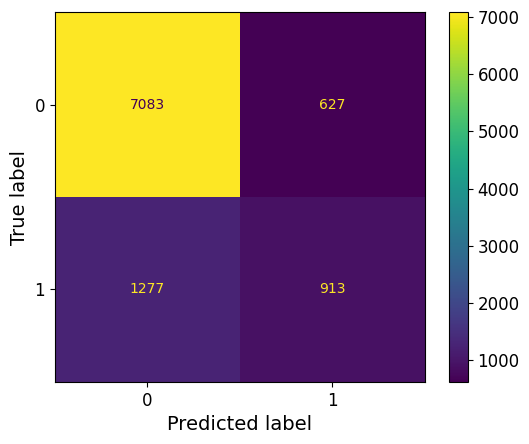

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder
# from category_encoders import OrdinalEncoder as COE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# log trasnform, outlier handling, feature selection, feature extraction?
coltrans = ColumnTransformer([
                            ('c_nom', OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore'), noms),
#                             ('c_ord', COE(mapping=orddict,cols=ordinals,handle_unknown="return_nan"), ords), #zaten encode edilmiş
                            ('c_num', MinMaxScaler(), nums)
                            ]
                            ,remainder = 'passthrough')

pipelogreg = Pipeline(steps =[
                        ('trf', coltrans),
                        ('clf', LogisticRegression(max_iter=1000,class_weight= cw))
                        ])

set_config(display="diagram")
pipelogreg
outputModel(pipelogreg)

* recall: realitede pozitif olanları tahminleme beceresi,
* precision: poz tahminlediklerim ne kadar doğru:

pozitif tahmin, ama negatif: False Positif: batar dedik batmadı, kardan zarar, aylık 2bin TL kabyımız olur, precision?
negatif tahmin, ama pozitif: False Negatif, batmaz dedik, battı, 150bin direkt zarar, recall?

recall ağırlıklı bir problem:

f-beta:5

Overfitting görünmüyor ancak positive classın tahminlemesi zayıf kalmış, grid search sırasında weight için 3 ve 4 değerlerini de deneyebiliriz

/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


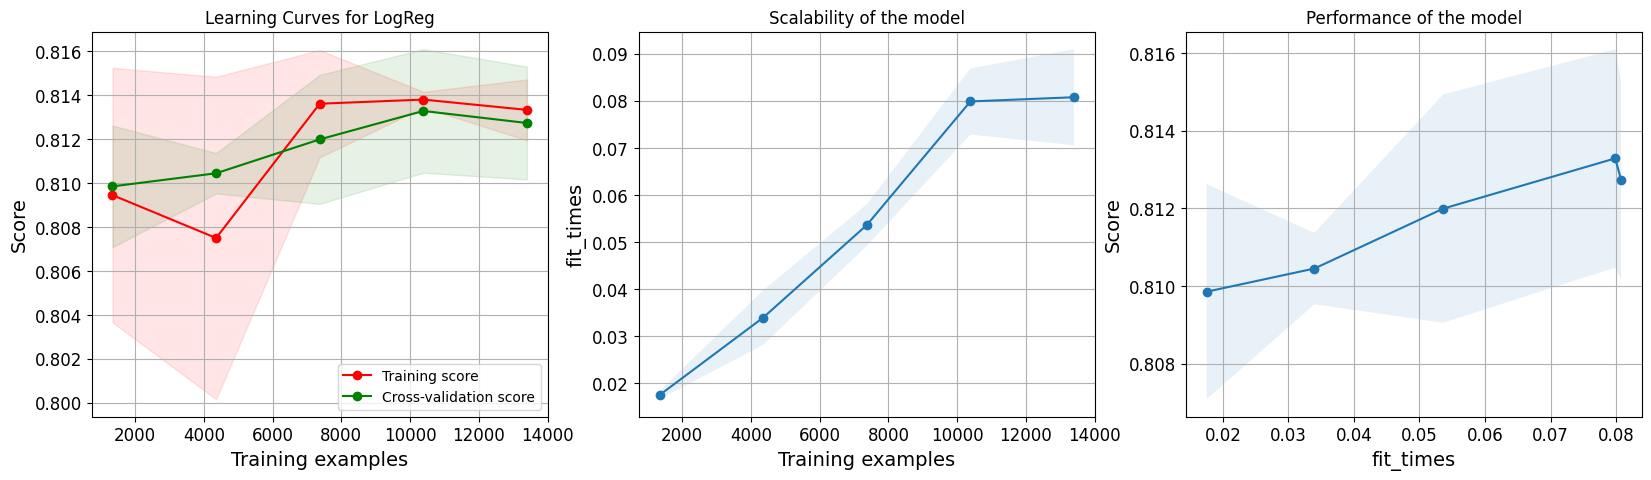

In [38]:
title = 'Learning Curves for LogReg'
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
ml.plot_learning_curve(pipelogreg, title, X_train, y_train, cv=kfold)
plt.show();

#### RandomForest

Printing cross_val scores....

[0.79557344 0.79273363 0.79633475]
Printing train results....

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15654
           1       1.00      1.00      1.00      4446

    accuracy                           1.00     20100
   macro avg       1.00      1.00      1.00     20100
weighted avg       1.00      1.00      1.00     20100

Printing test results....

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7710
           1       0.65      0.35      0.45      2190

    accuracy                           0.81      9900
   macro avg       0.74      0.65      0.67      9900
weighted avg       0.79      0.81      0.79      9900



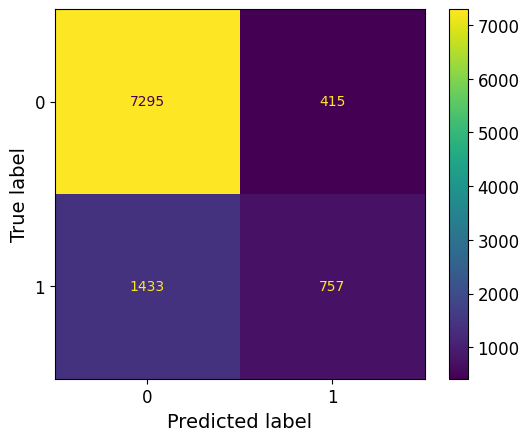

In [39]:
from sklearn.ensemble import RandomForestClassifier
coltrans = ColumnTransformer([
                            ('c_nom', OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore'), noms),
#                             ('c_ord', COE(mapping=orddict,cols=ordinals,handle_unknown="return_nan"), ords), #zaten encode edilmiş
                            ('c_num', MinMaxScaler(), nums)
                            ]
                            ,remainder = 'passthrough')

piperf= Pipeline(steps =[
                        ('trf', coltrans),
                        ('clf', RandomForestClassifier(random_state=42,class_weight=cw))
                        ])

set_config(display="diagram")
outputModel(piperf)

/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


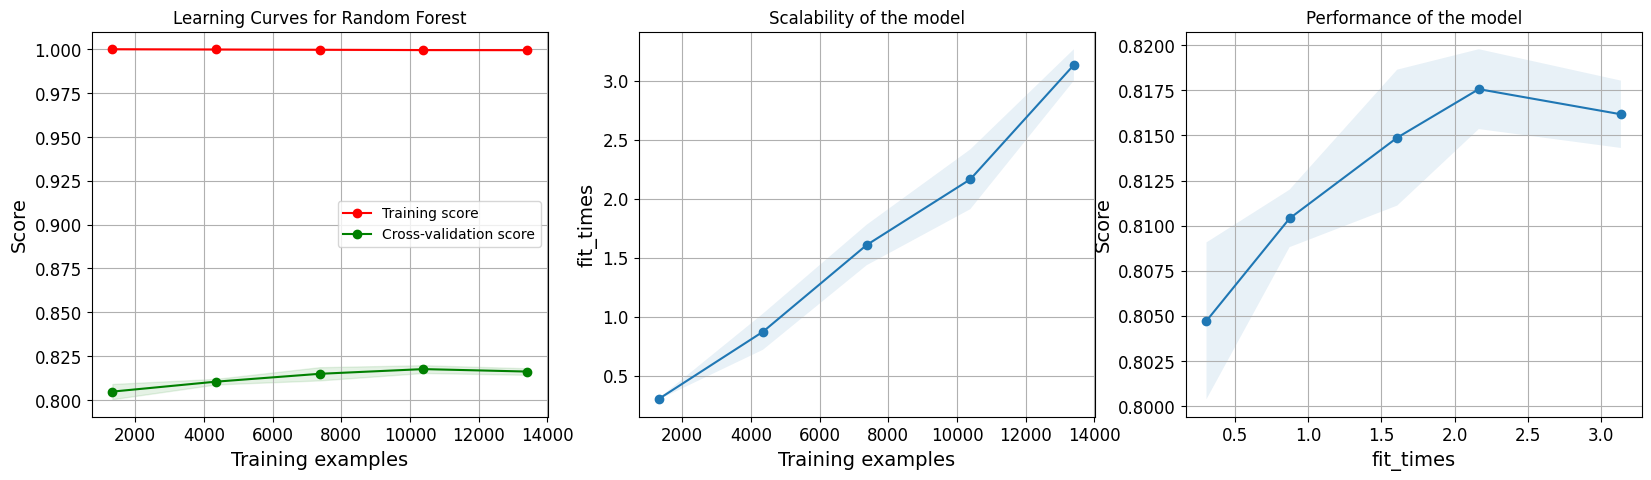

In [40]:
title = 'Learning Curves for Random Forest'
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
ml.plot_learning_curve(piperf, title, X_train, y_train, cv=kfold)
plt.show();

Yüksek bir overfitting durumu sözkonusu, üstelik size arttıkça train-test arası gap de kapancak gibi değil. gridsearche kalacak modellerden olmayacak.

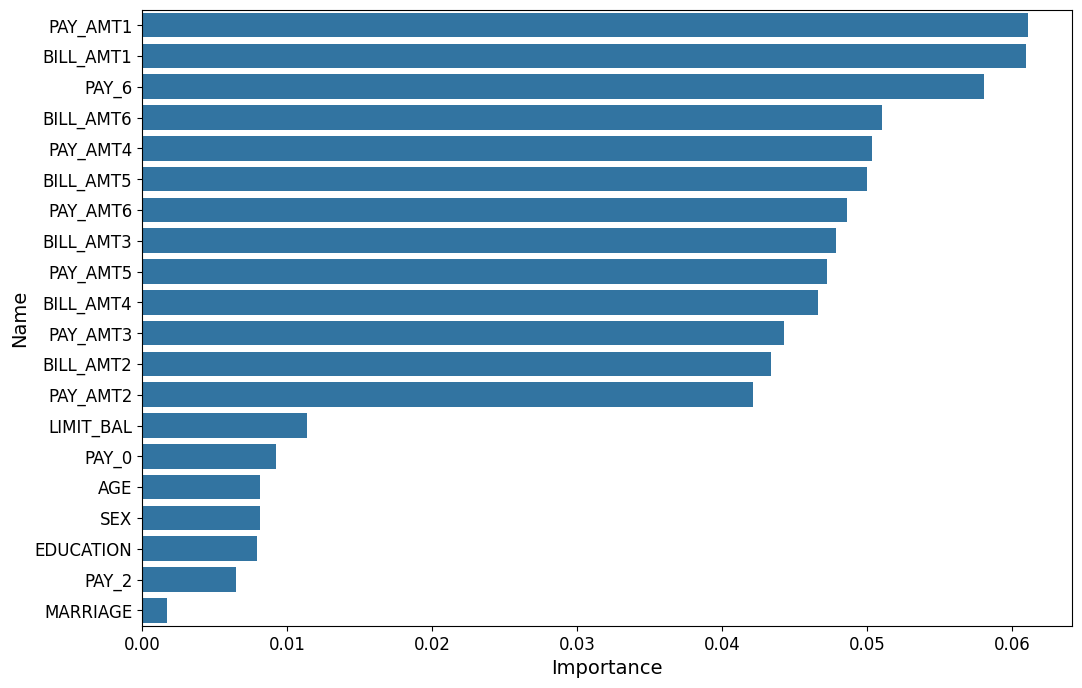

In [41]:
# importanceDf = pd.DataFrame([], columns=["Name", "Importance"])
# for name, importance in zip(X.columns, piperf["clf"].feature_importances_):
#     importanceDf = importanceDf.append(pd.Series({"Name":name, "Importance":importance}), ignore_index=True)
# importanceDf = importanceDf.sort_values(by="Importance", ascending=False).reset_index(drop=True)

rows = [pd.Series({"Name": name, "Importance": imp}) for name, imp in zip(X.columns, piperf["clf"].feature_importances_)]
importanceDf = pd.concat(rows, axis=1).T.reset_index(drop=True)
importanceDf = importanceDf.sort_values(by="Importance", ascending=False).reset_index(drop=True)

plt.figure(figsize=(12,8))
sns.barplot(data = importanceDf[:20], x="Importance", y="Name");

#### SVM

Printing cross_val scores....

[0.80032333 0.79810491 0.79827191]
Printing train results....

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     15654
           1       0.59      0.51      0.55      4446

    accuracy                           0.81     20100
   macro avg       0.73      0.70      0.71     20100
weighted avg       0.80      0.81      0.81     20100

Printing test results....

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      7710
           1       0.56      0.48      0.52      2190

    accuracy                           0.80      9900
   macro avg       0.71      0.69      0.70      9900
weighted avg       0.79      0.80      0.80      9900



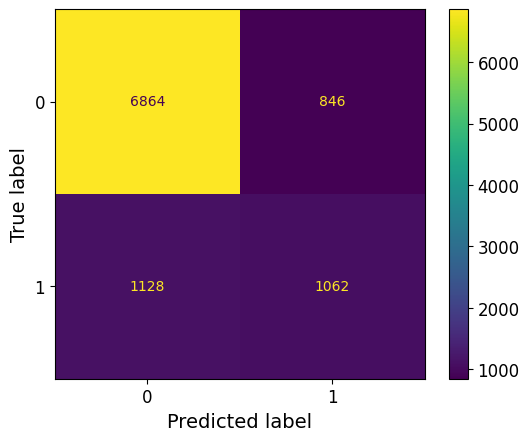

In [42]:
from sklearn.svm import SVC

coltrans = ColumnTransformer([
                            ('c_nom', OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore'), noms),
#                             ('c_ord', COE(mapping=orddict,cols=ordinals,handle_unknown="return_nan"), ords), #zaten encode edilmiş
                            ('c_num', MinMaxScaler(), nums)
                            ]
                            ,remainder = 'passthrough')

pipesvm= Pipeline(steps =[
                        ('trf', coltrans),
                        ('clf', SVC(random_state=42,class_weight=cw))
                        ])

set_config(display="diagram")
outputModel(pipesvm)

/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


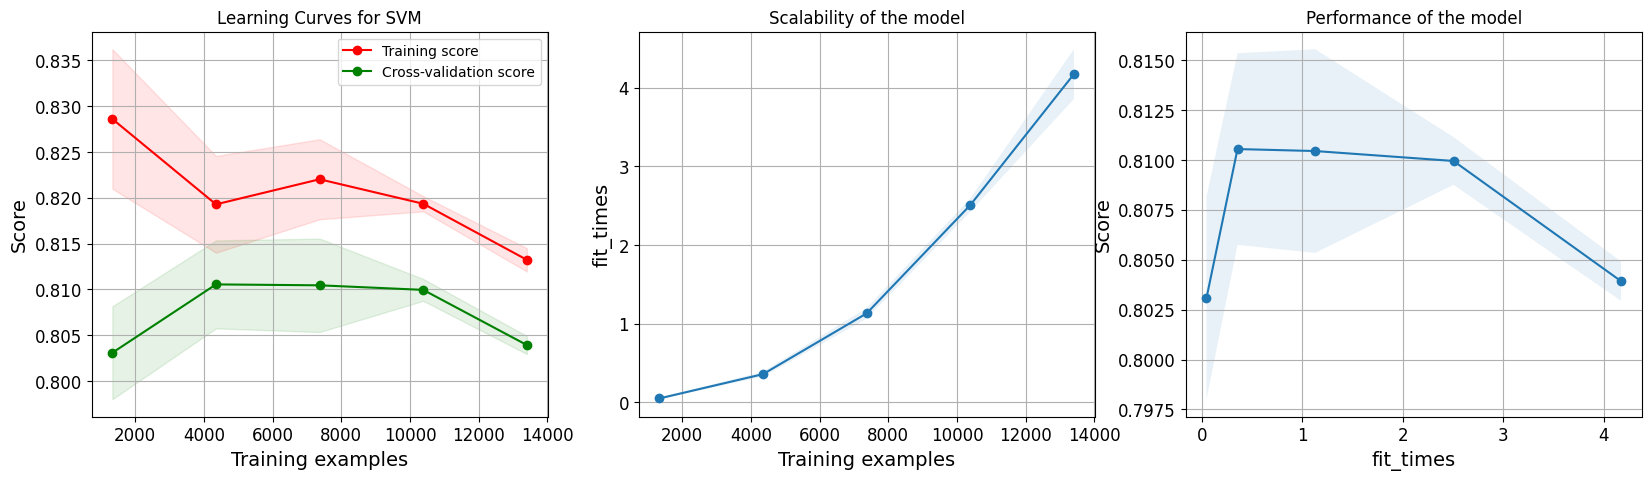

In [43]:
title = 'Learning Curves for SVM'
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
ml.plot_learning_curve(pipesvm, title, X_train, y_train, cv=kfold)
plt.show();

iterasyon sayısı artırılarak grid sarchde denenebilir.

### En iyi 3 için GridSearch

Overfitting durumuna ve test skorlarıan bakarak LogREg, SVM ve MLP'yi almaya karar verdim.

#### LogReg

In [46]:
coltrans = ColumnTransformer([
                            ('c_nom', OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore'), noms),
                            ('c_num', MinMaxScaler(), nums)
                            ]
                            ,remainder = 'passthrough')

params = [{'clf__C'      : np.arange(0.1, 1, 0.1), 
           'clf__l1_ratio': [1], 
           'clf__max_iter': [1000],
           'clf__class_weight': [{0:1, 1:x} for x in range(2,5)], 
           'clf__solver' : ['liblinear', 'saga'] }  ,
          {
           'clf__C'      : np.arange(0.1, 1, 0.1), 
           'clf__l1_ratio': [0], 
           'clf__max_iter': [1000], 
           'clf__class_weight': [{0:1, 1:x} for x in range(2,5)], 
           'clf__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}  
         ]

pipelogreg = Pipeline(steps =[
                        ('trf', coltrans),                        
                        ('clf', LogisticRegression(random_state=42))
                        ])


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_log = GridSearchCV(estimator = pipelogreg, param_grid = params, cv = cv, n_jobs = -1,verbose = 1, scoring = 'f1_weighted') #f1_weighted?
grid_log.fit(X_train, y_train)

Fitting 3 folds for each of 189 candidates, totalling 567 fits


/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': array([0.1, 0....7, 0.8, 0.9]), 'clf__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, ...], 'clf__l1_ratio': [1], 'clf__max_iter': [1000], ...}, {'clf__C': array([0.1, 0....7, 0.8, 0.9]), 'clf__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, ...], 'clf__l1_ratio': [0], 'clf__max_iter': [1000], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_weighted'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv

In [47]:
grid_log.best_params_

{'clf__C': np.float64(0.1),
 'clf__class_weight': {0: 1, 1: 2},
 'clf__l1_ratio': 0,
 'clf__max_iter': 1000,
 'clf__solver': 'sag'}

In [48]:
grid_log.best_score_

np.float64(0.801472941514196)

Printing cross_val scores....

[0.80332252 0.79821181 0.80288449]
Printing train results....

              precision    recall  f1-score   support

           0       0.85      0.92      0.89     15654
           1       0.61      0.43      0.51      4446

    accuracy                           0.81     20100
   macro avg       0.73      0.68      0.70     20100
weighted avg       0.80      0.81      0.80     20100

Printing test results....

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      7710
           1       0.59      0.42      0.49      2190

    accuracy                           0.81      9900
   macro avg       0.72      0.67      0.69      9900
weighted avg       0.79      0.81      0.80      9900



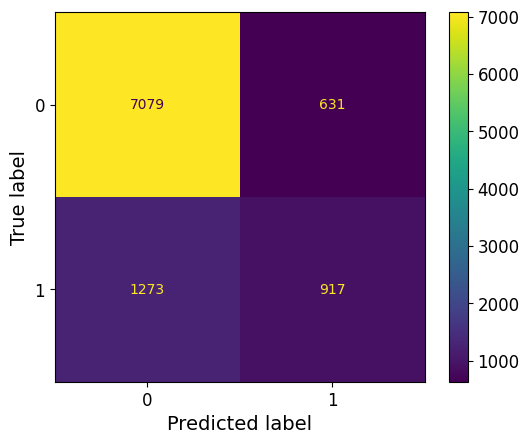

In [49]:
outputModel(grid_log.best_estimator_)

/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


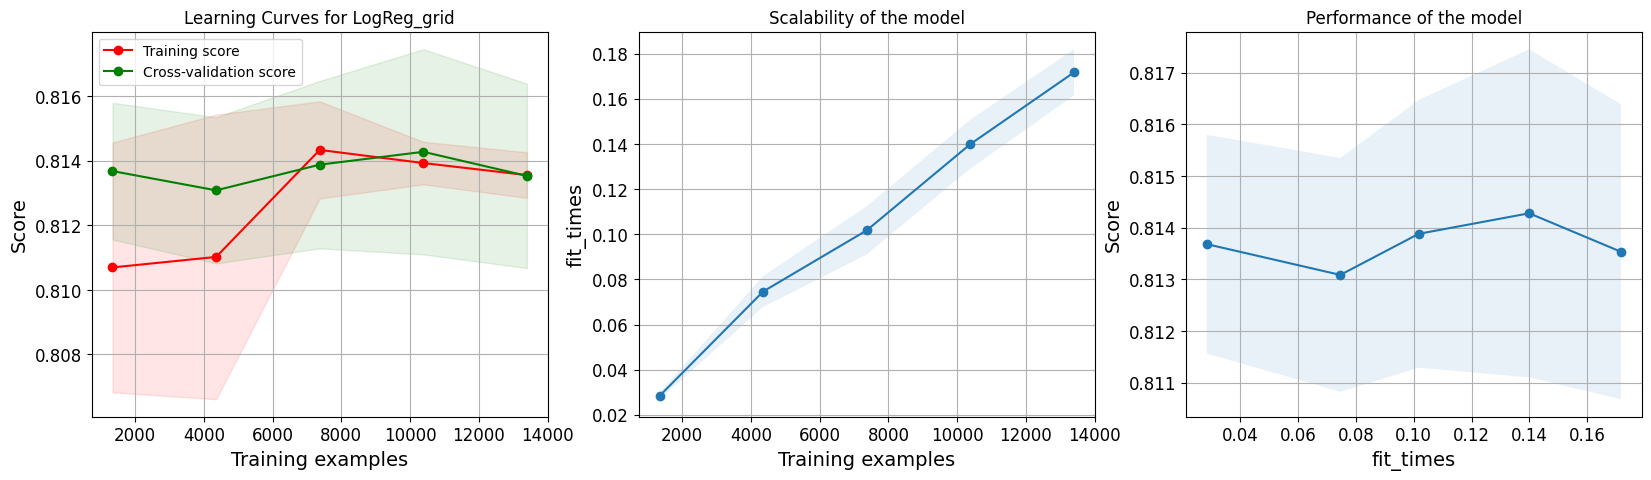

In [50]:
title = 'Learning Curves for LogReg_grid'
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
ml.plot_learning_curve(grid_log.best_estimator_, title, X_train, y_train, cv=kfold)
plt.show();

Base modele göre 1 puan artış var ve nerdeyse hiç overfit etmiyoruz.

#### SVM

In [52]:
coltrans = ColumnTransformer([
                            ('c_nom', OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore'), noms),
                            ('c_num', MinMaxScaler(), nums)
                            ]
                            ,remainder = 'passthrough')

param_grid = [
              {'clf__kernel': ['rbf'],
               'clf__gamma' : [1, 10, 100, 1000],
               'clf__class_weight': [{0:1, 1:x} for x in range(2,5)], 
               'clf__C'    : [0.01, 0.1, 1, 10]}
             ]

pipesvm = Pipeline(steps =[
                        ('trf', coltrans),
                        ('clf', SVC(random_state=42))
                        ])


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_svm = GridSearchCV(estimator = pipesvm, param_grid = param_grid, cv = cv, n_jobs = -1,verbose = 1, scoring = 'f1_weighted') 
grid_svm.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.01, 0.1, ...], 'clf__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, ...], 'clf__gamma': [1, 10, ...], 'clf__kernel': ['rbf']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_weighted'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- 

In [53]:
grid_svm.best_params_

{'clf__C': 1,
 'clf__class_weight': {0: 1, 1: 2},
 'clf__gamma': 1,
 'clf__kernel': 'rbf'}

In [54]:
grid_svm.best_score_

np.float64(0.7818706546693507)

Printing cross_val scores....

[0.77834596 0.78409301 0.78317299]
Printing train results....

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     15654
           1       0.70      0.60      0.64      4446

    accuracy                           0.85     20100
   macro avg       0.79      0.76      0.78     20100
weighted avg       0.85      0.85      0.85     20100

Printing test results....

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      7710
           1       0.53      0.43      0.48      2190

    accuracy                           0.79      9900
   macro avg       0.69      0.66      0.67      9900
weighted avg       0.78      0.79      0.78      9900



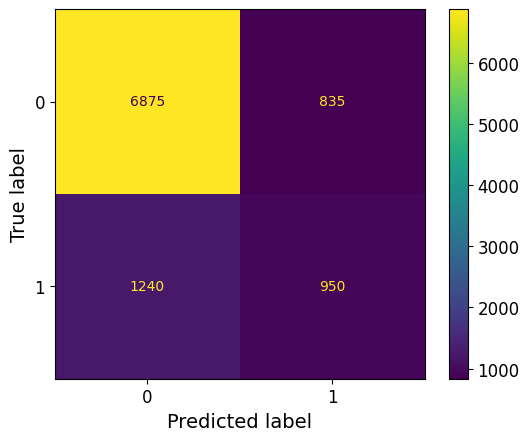

In [55]:
outputModel(grid_svm.best_estimator_)

/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


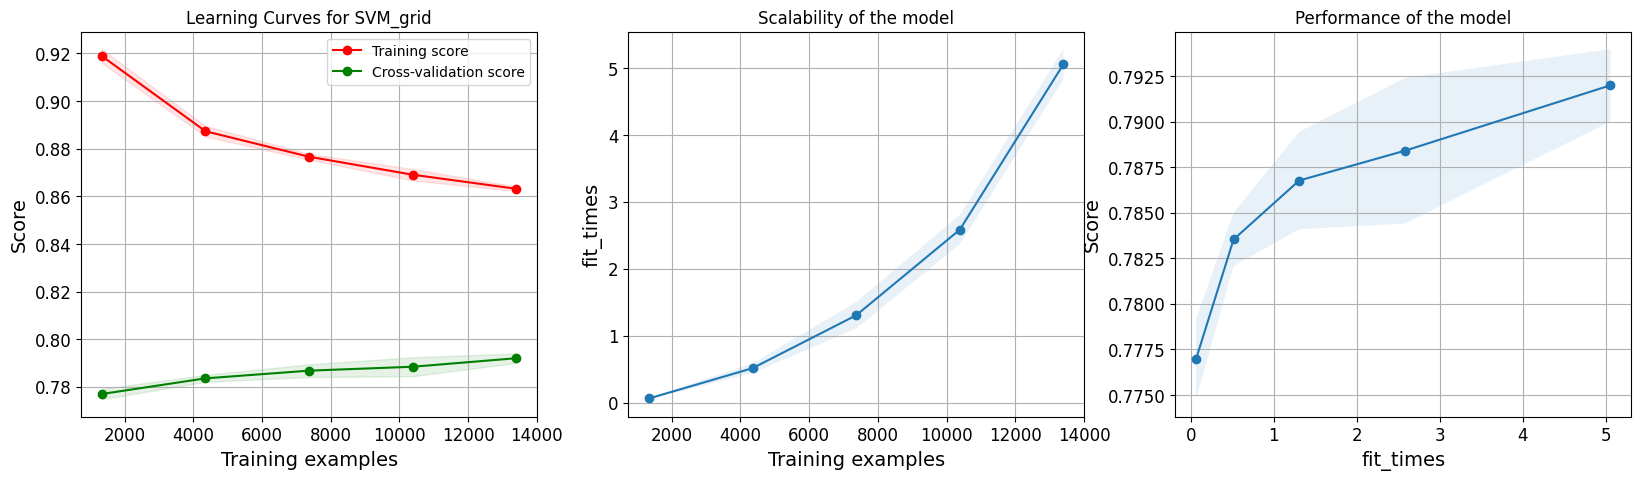

In [56]:
title = 'Learning Curves for SVM_grid'
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
ml.plot_learning_curve(grid_svm.best_estimator_, title, X_train, y_train, cv=kfold)
plt.show();

Base modele göre daha kötü bi seçim oldu, demekki parametreleri iyi seçemedik. Ancak zaman kısıtı nedeniyle yeniden deneyemeyeceğim.

## Oversampling

In [57]:
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN

In [58]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [59]:
X_train.shape

(20100, 23)

In [60]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [61]:
X_res.shape

(46728, 23)

In [62]:
y.valuecounts_()

array([[    0, 23364],
       [    1,  6636]])

In [63]:
y_res.valuecounts_()

array([[    0, 23364],
       [    1, 23364]])

In [64]:
X_res.SEX.unique(), X_res.EDUCATION.unique() #veri tipi koruması + Komşuların Tamamı Aynıysa

(array([2, 1]), array([2, 1, 3, 5, 4, 6, 0]))

### SMOTENC

In [65]:
[(x,e) for e,x in enumerate(X.columns) if x in cats]

[('SEX', 1),
 ('EDUCATION', 2),
 ('MARRIAGE', 3),
 ('PAY_0', 5),
 ('PAY_2', 6),
 ('PAY_3', 7),
 ('PAY_4', 8),
 ('PAY_5', 9),
 ('PAY_6', 10)]

In [ ]:
from imblearn.pipeline import Pipeline as S_Pipeline

coltrans = ColumnTransformer([
                            ('c_nom', OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore'), noms),
                            ('c_num', MinMaxScaler(), nums)
                            ]
                            ,remainder = 'passthrough')

params = [{'clf__C'      : np.arange(0.1, 1, 0.1), 
           'clf__l1_ratio': [1], 
           'clf__max_iter': [1000],
           'clf__class_weight': [{0:1, 1:x} for x in range(2,5)], 
           'clf__solver' : ['liblinear', 'saga'] }  ,
          {
           'clf__C'      : np.arange(0.1, 1, 0.1), 
           'clf__l1_ratio': [0], 
           'clf__max_iter': [1000], 
           'clf__class_weight': [{0:1, 1:x} for x in range(2,5)], 
           'clf__solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}  
         ]

# DİKKAT: SMOTENC, OHE öncedesinde yapılmalı
pipelogreg = S_Pipeline(steps =[
                        ('trf', coltrans),                                     
                        ('sampler', SMOTENC(categorical_features=[e for e,x in enumerate(X.columns) if x in cats], random_state=42)),
                        ('clf', LogisticRegression(random_state=42))
                        ])


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_log = GridSearchCV(estimator = pipelogreg, param_grid = params, cv = cv, n_jobs = -1,verbose = 1, scoring = 'f1_weighted') #f1_weighted?
grid_log.fit(X_train, y_train)

Fitting 3 folds for each of 189 candidates, totalling 567 fits
